In [3]:
import os 

original_dir = "Konkle_Objects_Colored"
resized_dir = "Resized_Konkle_Objects_Colored"
rotated_dir = "Rotated_Konkle_Objects_Colored"

transformations = {
    "resized": ["height_scaled_0.25",
                "height_scaled_0.50",
                "width_scaled_0.25",
                "width_scaled_0.50"],
    "rotated": ["rotated_90",
                "rotated_180",
                "rotated_270"]
}

original_images = os.listdir(original_dir)
resized_images = os.listdir(resized_dir)
rotated_images = os.listdir(rotated_dir)

transformations_mapping = {}

# Ensure the filenames are the same across directories
for original_image in original_images:
    full_original_path = os.path.join(original_dir, original_image)
    prefix = original_image.split(".")[0]
    
    transformations_mapping[full_original_path] = []
    for manip in transformations["rotated"]:
        new_fp = f"{prefix}_{manip}.jpg"
        assert new_fp in rotated_images
        transformations_mapping[full_original_path].append((os.path.join(rotated_dir, new_fp), manip))
    
    for manip in transformations["resized"]:
        new_fp = f"{prefix}_{manip}.jpg"
        assert new_fp in resized_images
        transformations_mapping[full_original_path].append((os.path.join(resized_dir, new_fp), manip))
    


In [4]:
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import torch
from multimodal.multimodal_lit import MultiModalLitModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading model...")
cvcl, preprocess = MultiModalLitModel.load_model(model_name="cvcl")
cvcl = cvcl.to(device)
cvcl.eval()

# encoding images
normalizer = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize each channel

preprocess = transforms.Compose([
            transforms.Resize((224, 224),
                              interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            normalizer,
        ])
vocab_dict = cvcl.vocab

Loading model...


/Users/mirandazhu/anaconda3/envs/schuster/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
  rank_zero_warn(
/Users/mirandazhu/anaconda3/envs/schuster/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.
  rank_zero_warn(


In [18]:
from tqdm import tqdm
similarity_scores = []

for base in tqdm(transformations_mapping):
    transformed = transformations_mapping[base]
    original_I = preprocess(Image.open(base).convert('RGB')).unsqueeze(0).to(device)
    original_image_features, _ = cvcl.model.encode_image(original_I)
    distance_score_self = F.pairwise_distance(original_image_features, original_image_features, p=2).item()
    similarity_scores.append({"type": "self", "distance":distance_score_self, "base":base})

    
    for t, type in transformed:
        transformed_I = preprocess(Image.open(t).convert('RGB')).unsqueeze(0).to(device)
        transformed_image_features, _ = cvcl.model.encode_image(transformed_I)
        distance_score = F.pairwise_distance(original_image_features, transformed_image_features, p=2).item() # the smaller the closer
        similarity_scores.append({"type": type, "distance":distance_score, "base":base})



100%|██████████| 475/475 [03:33<00:00,  2.23it/s]


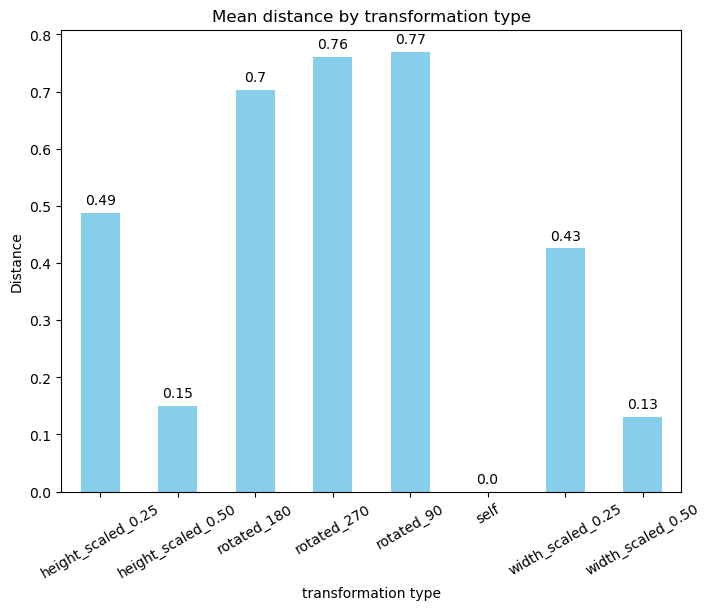

In [21]:
import pandas as pd
import matplotlib.pyplot as plt


similarity_df = pd.DataFrame(similarity_scores)

grouped_df = similarity_df.groupby('type')['distance'].mean()

# Plotting
plt.figure(figsize=(8, 6))
ax = grouped_df.plot(kind='bar', color='skyblue')
plt.title('Mean distance by transformation type')
plt.xlabel('transformation type')
plt.ylabel('Distance')
plt.xticks(rotation=30)  # Rotate x labels if needed

# Annotate each bar with its mean value
for index, value in enumerate(grouped_df):
    ax.text(index, value+0.01, round(value, 2), ha='center', va='bottom')

plt.show()

In [22]:
set(similarity_df["type"].values)

{'height_scaled_0.25',
 'height_scaled_0.50',
 'rotated_180',
 'rotated_270',
 'rotated_90',
 'self',
 'width_scaled_0.25',
 'width_scaled_0.50'}